In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import random
import seaborn as sns
import warnings
import time

import tensorflow as tf
from tensorflow.keras.layers import *
# Oversampling
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings("ignore")

In [2]:
seed = 101

In [3]:
df = pd.read_csv(r'dataset_fix2.csv', header=0)
df = df.drop(['no', 'bloodPressure'], axis=1)


In [4]:
df

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,P,20,88,36.0,1,1,1,0,1
1,68,p,23,70,36.0,1,1,1,0,1
2,62,p,20,83,36.8,1,1,0,0,1
3,54,L,22,88,37.0,1,0,0,0,1
4,83,L,18,82,36.8,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1550,63,P,20,95,35.5,1,0,0,0,0
1551,60,L,20,75,36.7,0,0,1,0,0
1552,50,L,18,80,36.8,0,0,1,0,0
1553,53,L,22,70,37.2,1,0,0,0,0


In [5]:
df.describe()

,age,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,52.829582,20.181994,77.218650,36.510611,0.362058,0.022508,0.158199,0.278457,0.099035
std,9.369569,1.748965,12.981317,0.903936,0.480750,0.148376,0.365045,0.448384,0.298806
min,32.000000,18.000000,50.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,19.000000,69.000000,35.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,20.000000,75.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,21.000000,85.000000,37.300000,1.000000,0.000000,0.000000,1.000000,0.000000
max,92.000000,40.000000,155.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

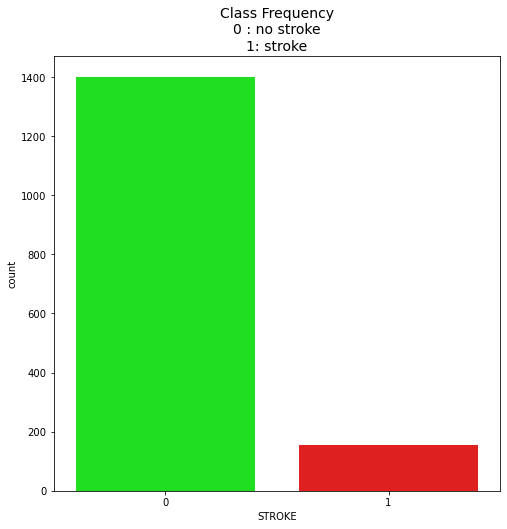

In [6]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=df, ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

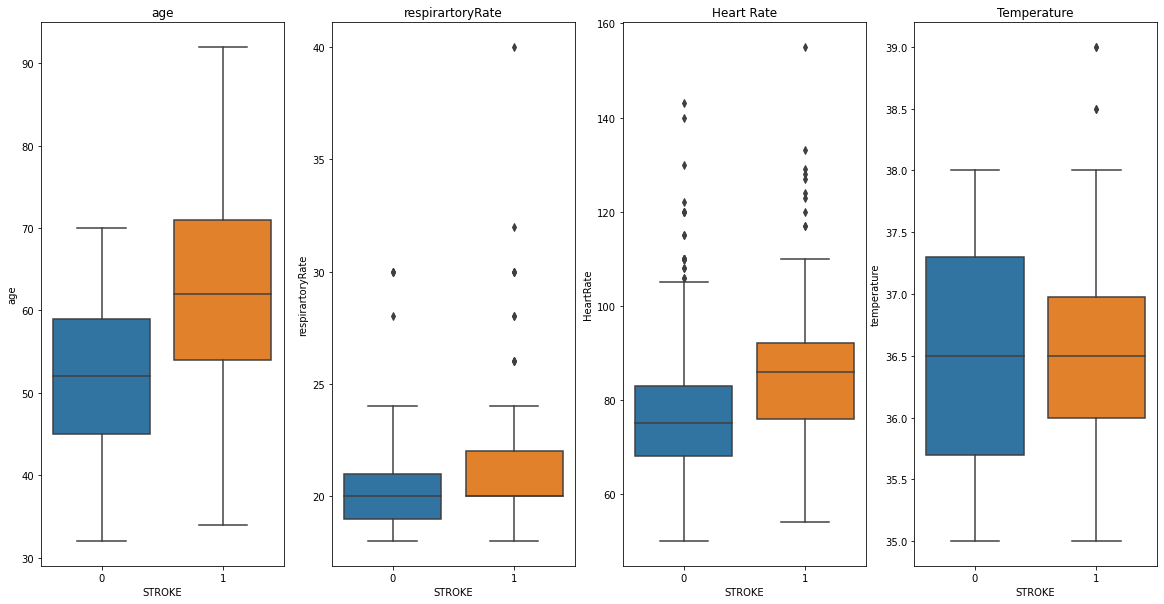

In [7]:
f, axes= plt.subplots(1, 4, figsize = (20, 10))
sns.boxplot(x="STROKE", y="age", data =df, ax=axes[0]).set_title('age')
sns.boxplot(x="STROKE", y="respirartoryRate", data =df, ax=axes[1]).set_title('respirartoryRate')
sns.boxplot(x="STROKE", y="HeartRate", data=df, ax=axes[2]).set_title('Heart Rate')
sns.boxplot(x="STROKE", y="temperature", data=df, ax=axes[3]).set_title('Temperature')
plt.show()

In [8]:
# Convert categorical values to numeric

In [9]:
gender = {'L': 0, 'l' : 0, 'P': 1, 'p' : 1}
df['gender'] = df['gender'].map(gender)

In [10]:
df.head()

,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,76,1,20,88,36.0,1,1,1,0,1
1,68,1,23,70,36.0,1,1,1,0,1
2,62,1,20,83,36.8,1,1,0,0,1
3,54,0,22,88,37.0,1,0,0,0,1
4,83,0,18,82,36.8,1,0,0,1,1


In [11]:
X = df
y = X.pop('STROKE')

# Intialize Model

In [12]:
def baseline_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(len(X.columns),)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

In [13]:
model = baseline_model()

In [14]:
model.fit(X,y)

Train on 1555 samples
1555/1555 [==============================] - 1s 610us/sample - loss: 0.7320 - accuracy: 0.8489


In [15]:
#m = tf.keras.metrics.Recall()
#m.update_state(np.array(y_res), model.predict_classes(X_res).flatten())
#m.result().numpy()


NameError: name 'y_res' is not defined

# Oversample dataset

In [16]:
X_res , y_res = RandomOverSampler().fit_resample(X, y)

In [17]:
# Fit Model

In [18]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_acc = []
test_acc = []
for train_index, test_index in skf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    model = baseline_model()
    model.fit(X_train, y_train)
    
    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_train), y_train)
    trainScore = m.result().numpy()

    m = tf.keras.metrics.Accuracy()
    m.update_state(model.predict_classes(X_test), y_test)
    testScore = m.result().numpy()

    
    train_acc.append(trainScore)
    test_acc.append(testScore)

Train on 2241 samples
2241/2241 [==============================] - 1s 292us/sample - loss: 0.8557 - accuracy: 0.6225
Train on 2241 samples
2241/2241 [==============================] - 1s 290us/sample - loss: 0.8737 - accuracy: 0.5257
Train on 2242 samples
2242/2242 [==============================] - 1s 306us/sample - loss: 0.8037 - accuracy: 0.6320
Train on 2242 samples
2242/2242 [==============================] - 1s 297us/sample - loss: 0.8846 - accuracy: 0.6459
Train on 2242 samples
2242/2242 [==============================] - 1s 327us/sample - loss: 0.7047 - accuracy: 0.6432


In [19]:
train_acc

[0.72066045, 0.69076306, 0.72970563, 0.64629793, 0.6543265]

In [20]:
test_acc

[0.7112299, 0.6898396, 0.7375, 0.6375, 0.65]

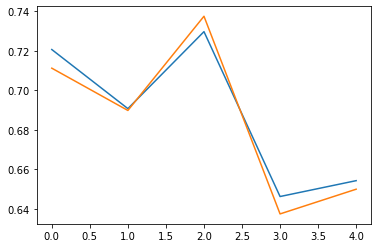

In [21]:
plt.plot(train_acc)
plt.plot(test_acc)

In [22]:
X_test = X_test.reset_index().drop(['index'], axis=1)

## Predict individual sample

In [23]:
index = 3 # or any other number

In [24]:
test_sample = X_test.loc[index]
test_sample = np.array(test_sample).reshape(1, -1)

In [26]:
model.predict(test_sample)

array([[0.5940568]], dtype=float32)

In [27]:
y_test.reset_index().drop(['index'], axis=1).loc[index]

STROKE    1
Name: 3, dtype: int64